In [1]:
import videoIO as vio
import pandas as pd
import vplot as vp
import vmanipulation as vm
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as pyplay

df = pd.read_csv('../data.csv')
filesDir = '../Database/'
df['File'] = df.File.str[-16:]
df['File'] = filesDir + df['File']
df = df.rename(columns={'Time_duration (mm:ss)': 'Time_duration','Time_start (mm:ss.ms)':'Time_start'})

filename = df['File'][0] 
start = df['Time_start'][0]
duration = df['Time_duration'][0]

In [2]:
print(start,duration)
start = 51
duration = 24.5

00:51.0 00:24.5


In [ ]:
#A = vio.readAudio(filename, duration, start, mono=True)

In [3]:
def getffmpeg():
    import platform
    OS =  platform.system()
    
    # linux and MAC OS X
    if (OS == "Linux" or OS =="Darwin"):
        return "ffmpeg"
    # windows
    elif (OS == "Windows"):
        return "ffmpeg.exe"
    else:
        raise Exception("OS not identified") 
        
def getVideoInfo(filename):
    import re
    import subprocess as sp
    command_info = ['ffprobe', '-show_streams','-i', filename]
    pipe = sp.Popen(command_info, stdout=sp.PIPE,stderr=sp.STDOUT)
    stream = False
    videoInfo = {}
    currentChannel = None
    for x in pipe.stdout.readlines():
        if re.findall('\\bSTREAM\\b', x.decode()):
            stream = True
        if re.findall('\\b/STREAM\\b', x.decode()):
            stream = False
        if (stream) and ("STREAM" not in x.decode()):
            key, value = x.decode().strip('\n').split('=')
            if (key=="index"):
                videoInfo[int(value)] = {} #newchannel
                currentChannel = int(value)
            elif (currentChannel!= None):
                videoInfo[currentChannel][key] = value
    return videoInfo

def tofloat(string):
    try:
        return float(string)
    except ValueError:
        num, denom = string.split('/')
        try:
            return (float(num)/float(denom))
        except ValueError:
            print ("That was no valid number.")
            
def splitArray(array, numberOfBlocks, overlapping=0): 
    
    array_size = array.size
    step = int(np.ceil(array_size/numberOfBlocks))
    
    if isinstance(overlapping, float):
        overlapping = int(overlapping * step)
    
    splitArray = np.zeros((numberOfBlocks, step + overlapping))
    start = np.arange(0,array_size,step)
    stop = np.arange(step+overlapping,array_size,step)
    
    if len(start)!=len(stop):
        aux = np.ones(len(start)-len(stop)) * array_size
        stop = (np.append(stop,aux)).astype(int)
        
    for (i,(s,e)) in enumerate(zip(start, stop)):
        splitArray[i,:e-s] = array[s:e]
    return splitArray   
 

def splitList(alist, numberOfBlocks, overlapping=0): 
    
    list_size = len(alist)
    step = int(np.ceil(list_size/numberOfBlocks))
    
    if isinstance(overlapping, float):
        overlapping = int(overlapping * step)
    
    start = np.arange(0,list_size,step)
    stop = np.arange(step+overlapping,list_size,step)
    splitArray = []
    
    if len(start)!=len(stop):
        aux = np.ones(len(start)-len(stop)) * list_size
        stop = (np.append(stop,aux)).astype(int)
        
    for (s,e) in zip(start, stop):
        splitArray.append(alist[s:e])    
    return splitArray    
        

def splitVideo(filename, numberOfParts=1, start=None, duration=None, mono=True, numberOfBlocks=50, overlapping=0):
    import subprocess as sp
    import numpy as np
    
    ffmpeg = getffmpeg()
    videoInfo = getVideoInfo(filename)
    
    if duration == None:
        duration = str(videoInfo[0]['duration'])
    else:
        duration = str(duration)
        
    if start == None:
        start = '0'
    else:
        start = str(start)
    
    H, W = int(videoInfo[0]['height']) , int(videoInfo[0]['width'])
    frameRate = tofloat(videoInfo[0]['avg_frame_rate'])
    
    numberOfFrames = int(np.round(frameRate * float(duration)))
    
    sampleRate = videoInfo[1]['sample_rate']
    numberChannels = videoInfo[1]['channels']
    
    commandVideo = [ffmpeg, 
               '-i', filename, 
               '-ss', start,
               '-t', duration,
               '-f', 'image2pipe',
               '-pix_fmt', 'rgb24',
               '-vcodec', 'rawvideo','-']
    
    commandAudio = [ffmpeg,
            '-i', filename,
            '-ss', start,   
            '-t', duration,
            '-f', 's16le',
            '-acodec', 'pcm_s16le',
            '-ar', sampleRate,
            '-ac', numberChannels, 
            '-']
    
    pipeVideo = sp.Popen(commandVideo, stdout = sp.PIPE, bufsize=10**8)
    pipeAudio = sp.Popen(commandAudio, stdout = sp.PIPE, bufsize=10**8)
    
    frames=[]
    
    for it in range(numberOfFrames):
        raw_image = pipeVideo.stdout.read(H * W * 3)
        image =  np.fromstring(raw_image, dtype=np.uint8)
        if (image.size != 0):
            image = image.reshape((H,W,3))
            frames.append(image)
    pipeVideo.kill() 
    
    num = int(int(numberChannels)*int(sampleRate)*float(duration))
    raw_audio = pipeAudio.stdout.read(num*2)
    audio_array = np.fromstring(raw_audio, dtype="int16")
    
    if int(numberChannels) > 1:
        audio_array = audio_array.reshape((len(audio_array)//int(numberChannels),int(numberChannels)))
    pipeAudio.kill()
    
    audioChunks = splitArray(audio_array[:,0],numberOfBlocks, overlapping) 
    videoChunks = splitList(frames, numberOfBlocks, overlapping)
    return videoChunks, audioChunks 
    
video, audio = splitVideo("../simple_database/BigVideo0.mp4", numberOfBlocks=50,overlapping=0.4)

In [ ]:
filename2 = df['File'][35] 
start2 = df['Time_start'][35]
duration2 = df['Time_duration'][35]
start2 = 8*60+33
duration2 = 23
video2, audio2 = splitVideo(filename2, start=start2,duration=duration2, numberOfBlocks=50,overlapping=0.4)


In [ ]:
#print(A.shape)

In [ ]:
#pyplay.Audio(A,rate=48000)
vm.displayAudioFrames(A, 48000)


In [7]:
import matplotlib.image as mpimg

def rgb2gray(rgbImg):
    import numpy as np
    return (np.dot(rgbImg[...,:3], [0.299, 0.587, 0.114])).astype(np.uint8)

def getFace(image, plot=False):
    import dlib
    
    detector = dlib.get_frontal_face_detector()
    if image.ndim > 2:
        grayImage = rgb2gray(image[:,:,:3])
        faceLocation = detector(grayImage)
    else:
        faceLocation = detector(image)
    
    if plot:
        import matplotlib.pyplot as plt
        import matplotlib.patches as patches
        fig, ax = plt.subplots(1)
        plt.imshow(image)
        for region in faceLocation:
            left, top, width, height = region.left(), region.top(), region.width(), region.height()
            pat = patches.Rectangle((left, top), width, height, linewidth=1, edgecolor='r',facecolor='none')
            ax.add_patch(pat)
        plt.show()
            
    return faceLocation 

def getFaceLandmarks(image, plot=False, array=True):
    import dlib
    import numpy as np

    grayImage = rgb2gray(image)
    faceLocation = getFace(grayImage)
    
    predictor = dlib.shape_predictor('/home/eu//Desktop/Personality_recognition/shape_predictor_68_face_landmarks.dat')
    #predictor = dlib.shape_predictor('/home/paula/Desktop/Personality_recognition/shape_predictor_68_face_landmarks.dat')

    for region in faceLocation:
        landmarks = predictor(grayImage, region)
    
    if plot:
        fig, ax = plt.subplots(1)
        plt.imshow(image)
        for points in list(landmarks.parts()):
            dots = patches.Circle( (points.x, points.y) , 5)
            ax.add_patch(dots)
        plt.show()    
    
    if array:
        landmarks_array = np.zeros((68,2), int)
        for i, points in enumerate (list(landmarks.parts())):
            landmarks_array[i,:] = np.array([points.x, points.y])
        return landmarks_array
    
    else:
        return landmarks

def plotFaceLandMarks(image, faceLandmarks, extraPoints=None):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    fig, ax = plt.subplots(1)
    plt.imshow(image)
    for i in range (faceLandmarks.shape[0]):
        dots = patches.Circle( faceLandmarks[i,:] , 10)
        ax.add_patch(dots)
    
    #if extra
    #plt.show() 
    
def splitShapes(faceLandmarks):
    
    jaw = faceLandmarks[:17]
    eyebrows = faceLandmarks[17:27]
    nose = faceLandmarks[27:36]
    eyes = faceLandmarks[36:48]
    mouth = faceLandmarks[48:]
    
    return jaw, eyebrows, nose, eyes, mouth

def displayFrames(listOfFrames):
    import matplotlib.pyplot as plt
    numberofFrames = len(listOfFrames)
    plt.figure(1, figsize=(12,32))
    for i, frame in enumerate(listOfFrames):
        plt.subplot(numberofFrames//2 + 1,2,i+1)
        plt.imshow(frame)
    plt.show()

def isLandmarks(landmarks):
        if landmarks.shape[0] != 68:
            return False
        else:
            return True
    
def getMeanFace(faceFrames, split=False):
    nvls = 0 # Number of Valid Landmarks Set
    meanFace = np.empty((0,2),int)
    for aFrame in faceFrames:
        faceLandmarks = getFaceLandmarks(aFrame)
        if isLandmarks(faceLandmarks):
            nvls += 1
            if (meanFace.shape[0]==0):
                meanFace = np.append(meanFace,faceLandmarks, axis=0)
            else:
                meanFace += faceLandmarks
    meanFace = meanFace // nvls        
    if split:
        return splitShapes(meanFace)
    else:
        return meanFace


In [ ]:
def getCentreOfGravity(faceLandmaks):
    return faceLandmaks.mean(axis=0).astype(np.int)
    
def derivateFaces(videoChunks):
    meanFaces = np.empty((0,68),int)
    progress = 0
    step = 100/len(videoChunks)
    for chunk in videoChunks:
        meanFaces = np.append(meanFaces,getMeanFace(chunk).T, axis=0)
        progress += step
        print ("progress: {:.2f} %".format(1.2345))
        print('progress: ', progress, ' %')
    
    derivatedFaces = meanFaces[2:,:] - meanFaces[:-2,:]  
    return derivatedFaces

fl = getFaceLandmarks(video[0][0])
cog = getCentreOfGravity(fl)

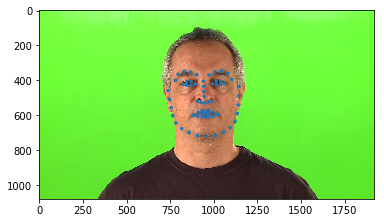

In [13]:
#print(fl)
#print(cog)
plotFaceLandMarks(video[0][0], fl)

In [ ]:
print(faceVariations)

In [ ]:
b = a[2:,:]-a[:-2,:]
print(a[2:,:])
print(a[:-2,:])


In [ ]:
import os

total = df.shape[0]
for idx, row in df.iterrows():
    #print(row['File'], row['Time_start'], row['Time_duration'])
    
    filename = row['File']
    start = row['Time_start']
    duration = row['Time_duration']
    outputFile = '../small_database/smallVideo'+ str(idx) + '.mp4'
    #print(outputFile)
    command = ('ffmpeg -y -i ' + filename + ' -ss ' + start + ' -t ' + duration + ' -s 640x480 -acodec aac ' +
               '-strict -2 ' + outputFile)
    print(command)
    os.system(command)
    #ffmpeg -i <inputfilename> -s 640x480 -b 512k -vcodec mpeg1video -acodec copy <outputfilename>
    
    if(idx>20):
        break

ffmpeg -y -i ../Database//579_0006_01.MP4 -ss 00:51.0 -t 00:24.5 -s 640x480 -acodec aac -strict -2 ../small_database/smallVideo0.mp4
ffmpeg -y -i ../Database//579_0006_01.MP4 -ss 02:58.0 -t 00:24.0 -s 640x480 -acodec aac -strict -2 ../small_database/smallVideo1.mp4
ffmpeg -y -i ../Database//579_0006_01.MP4 -ss 03:52.5 -t 00:33.0 -s 640x480 -acodec aac -strict -2 ../small_database/smallVideo2.mp4
ffmpeg -y -i ../Database//579_0006_01.MP4 -ss 04:49.0 -t 00:29.0 -s 640x480 -acodec aac -strict -2 ../small_database/smallVideo3.mp4
ffmpeg -y -i ../Database//579_0006_01.MP4 -ss 06:32.0 -t 00:29.0 -s 640x480 -acodec aac -strict -2 ../small_database/smallVideo4.mp4
ffmpeg -y -i ../Database//579_0006_01.MP4 -ss 07:14.0 -t 00:33.0 -s 640x480 -acodec aac -strict -2 ../small_database/smallVideo5.mp4
ffmpeg -y -i ../Database//579_0006_01.MP4 -ss 08:06.5 -t 00:20.0 -s 640x480 -acodec aac -strict -2 ../small_database/smallVideo6.mp4
ffmpeg -y -i ../Database//579_0006_01.MP4 -ss 08:42.5 -t 00:22.0 -s 6

In [ ]:
filename = df['File'][0] 
start = df['Time_start'][0]
duration = df['Time_duration'][0]
print(filename)
print(start)
print(duration)

In [ ]:
A = vio.readAudio("../Database/579_0006_01.MP4",start=start,duration="00:24.5",mono=True)
A = vm.normalize(A,normRange=[-1,1])
A = vm.removeDC(A)
pyplay.Audio(data=A,rate=48000)


In [ ]:
print(A.shape)

In [ ]:
print(getVideoInfo("../Database/579_0006_01.MP4")[0])

In [ ]:
def readFrames(filename, start="00:00:00", duration=None, framedrop=1, fd=None):
    import platform
    import subprocess as sp
    import numpy as np
    import videoIO as vio
    
    OS =  platform.system()
    if (OS == "Linux"):
        FFMPEG_BIN = "ffmpeg"
    elif (OS == "Windows"):
        FFMPEG_BIN = "ffmpeg.exe"
    else:
        raise Exception("OS not identified")   
    
    H,W = vio.getVideoResolution(filename)    
    fr = vio.getFrameRate(filename)
    nframes = int(fr * vio.timeStringToFloat(duration,timeFormat=[60,1]))
    if fd == None:
        fd = [H,W]
    
    command = [ FFMPEG_BIN,
            '-ss', start, 
            '-i', filename,
            '-t', duration,
            '-f', 'image2pipe',
            '-pix_fmt', 'rgb24',
            '-vcodec', 'rawvideo', '-']
    pipe = sp.Popen(command, stdout = sp.PIPE, bufsize=10**8)
    
    frameList=[]
    for f in range(nframes):
        raw_image = pipe.stdout.read(H * W * 3)
        image =  np.fromstring(raw_image, dtype=np.uint8)
        if (image.size != 0):
            if (f%framedrop==0):
                image = image.reshape((H,W,3))
                image = image[H//2-fd[0]//2:H//2+fd[0]//2, W//2-fd[1]//2:W//2+fd[1]//2,:]
                frameList.append(image)
    pipe.kill()            
    return frameList


readFrames('../Database/579_0006_01.MP4', start="00:00:00", duration=None, framedrop=1, fd=None)

In [ ]:
def plotSpectrum(y,Fs):
    """
    Plots a Single-Sided Amplitude Spectrum of y(t)
    """
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range
    
    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(n//2)]

    plt.plot(frq,abs(Y),'r') # plotting the spectrum
    plt.xlabel('Freq (Hz)')
    plt.ylabel('|Y(Freq)|')
    
    plt.show()
    
def energy(signal):
    return signal**2    

def dftWindows(windows):
    dftwin = []
    for w  in windows:
        dftw = np.fft.fft(w)
    
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
    
def melFrequency(f):
    return 1127 * np.log(1 + f/700)

def bark(f):
    a = 1
    return 13 * a * tan(f/1315.8) + 3.5 * a * tan(f/7518)

def logFrequency(f):
    return np.log2(f/1000)

def logAttackTime(attackStart, attackEnd):
    return np.log10(attackEnd - attackStart)

def temporalIncrease(attackStart, attackEnd, signal, mu = 0, sig = 0.5):
    averageEnergy = np.zeros(attackStart.size)
    for i, (s,e) in enumerate (zip(attackStart, attackEnd)):
        g = gaussian(np.linspace(-0.5, 0.5, e-s), mu, sig)    
        averageEnergy[i] = ( (signal[s:e]**2)*g ).mean()
    return averageEnergy

def temporalCentroid(signal,sampleRate):
    t = np.arange(0,signal.size,1)/sampleRate
    return sum( (signal**2)*t) / sum ((signal**2)) 
    

def findVoicedSegmants(signal, t, hold = 0):
    tVal = signal.max() * t
    signVariationArray = np.diff(np.sign(signal - tVal))
    (signVariationIdx,) = np.nonzero(signVariationArray)
    signVariationIdx = signVariationIdx.astype(float)
    
    signVariationIdx = np.insert(signVariationIdx,-1,float('inf'))
    signVariationIdx[-2:] = signVariationIdx[-1],signVariationIdx[-2]
    
    shiftIdx = np.zeros_like(signVariationIdx)
    shiftIdx[0] = float('-inf')
    shiftIdx[1:] = signVariationIdx[:-1]
    
    endSegments = shiftIdx[(abs(shiftIdx  - signVariationIdx)>hold)][1:]
    startSegments = signVariationIdx[(abs(shiftIdx  - signVariationIdx)>hold)][:-1]
    
    return (np.vstack((startSegments, endSegments)) ).astype(int)

def signalAutoCorrelation(signal, it_limit=None):
    signalLength = signal.size
    
    if it_limit == None:
        it_limit = signalLength
        
    signalCorrelation = np.zeros(it_limit)
    
    for i in range(it_limit):
        signalCorrelation[i] = sum(signal[0:signalLength-i] * signal[i:]) 
    return signalCorrelation


def energyVoicedSegments(signal, t, hold = 0):
    vs = findVoicedSegmants(signal, t, hold)
    energyVoice = 0
    for (s,e) in zip(attackStart, attackEnd):
        energyVoice += sum(energy(signal[s:e]))
    return energyVoice
    
def energyUnvoicedSegments(signal, t, hold = 0):
    return sum(energy(signal)) - energyVoicedSegments(signal,t,hold)


def spectralCentroid(signal, sampleRate):
    
    n = len(signal)
    fft_signal = np.fft.fft(signal) 
    fft_signal = fft_signal[:n//2]
    frequency = np.linspace(0,sampleRate,n)
    frequency = frequency[:n//2] 
    return sum(frequency * abs(fft_signal)) / sum(abs(fft_signal))  

def hammingWindow(windowSize):
    return 0.54-0.46*np.cos(2*np.pi*(np.arange(windowSize))/windowSize)

def STFT(signal, windowSize, overlapping=0):
    n = len(signal)
    padding = windowSize//2
    numberOfWindows = (np.floor( n / (windowSize - overlapping) ) ).astype(int)
    windowPadSize = padding * 2 + windowSize 
    windows = np.zeros((numberOfWindows, windowPadSize),np.complex)
    signal = np.append(signal, np.zeros(windowSize))
    for i in range(0, numberOfWindows): 
        windows[i,padding:-padding] = np.fft.fft(signal[i * (windowSize - overlapping):i * (windowSize - overlapping) + windowSize] 
                                       * hammingWindow(windowSize) )    
    return windows



In [ ]:
import six
import scipy
from numpy.lib.stride_tricks import as_strided
MAX_MEM_BLOCK = 2**8 * 2**10

def get_window(window, Nx, fftbins=True):
    if six.callable(window):
        return window(Nx)

    elif (isinstance(window, (six.string_types, tuple)) or
          np.isscalar(window)):
        # TODO: if we add custom window functions in librosa, call them here

        return scipy.signal.get_window(window, Nx, fftbins=fftbins)

    elif isinstance(window, (np.ndarray, list)):
        if len(window) == Nx:
            return np.asarray(window)

        raise ParameterError('Window size mismatch: '
                             '{:d} != {:d}'.format(len(window), Nx))
    else:
        raise ParameterError('Invalid window specification: {}'.format(window))

def pad_center(data, size, axis=-1, **kwargs):

    kwargs.setdefault('mode', 'constant')

    n = data.shape[axis]

    lpad = int((size - n) // 2)

    lengths = [(0, 0)] * data.ndim
    lengths[axis] = (lpad, int(size - n - lpad))

    if lpad < 0:
        raise ParameterError(('Target size ({:d}) must be '
                              'at least input size ({:d})').format(size, n))

    return np.pad(data, lengths, **kwargs)

def valid_audio(y, mono=True):

    if not isinstance(y, np.ndarray):
        raise ParameterError('data must be of type numpy.ndarray')

    if not np.issubdtype(y.dtype, np.float):
        raise ParameterError('data must be floating-point')

    if mono and y.ndim != 1:
        raise ParameterError('Invalid shape for monophonic audio: '
                             'ndim={:d}, shape={}'.format(y.ndim, y.shape))

    elif y.ndim > 2 or y.ndim == 0:
        raise ParameterError('Audio must have shape (samples,) or (channels, samples). '
                             'Received shape={}'.format(y.shape))

    if not np.isfinite(y).all():
        raise ParameterError('Audio buffer is not finite everywhere')

    return True

def frame(y, frame_length=2048, hop_length=512):

    if not isinstance(y, np.ndarray):
        raise ParameterError('Input must be of type numpy.ndarray, '
                             'given type(y)={}'.format(type(y)))

    if y.ndim != 1:
        raise ParameterError('Input must be one-dimensional, '
                             'given y.ndim={}'.format(y.ndim))

    if len(y) < frame_length:
        raise ParameterError('Buffer is too short (n={:d})'
                             ' for frame_length={:d}'.format(len(y), frame_length))

    if hop_length < 1:
        raise ParameterError('Invalid hop_length: {:d}'.format(hop_length))

    if not y.flags['C_CONTIGUOUS']:
        raise ParameterError('Input buffer must be contiguous.')

    # Compute the number of frames that will fit. The end may get truncated.
    n_frames = 1 + int((len(y) - frame_length) / hop_length)

    # Vertical stride is one sample
    # Horizontal stride is `hop_length` samples
    y_frames = as_strided(y, shape=(frame_length, n_frames),
                          strides=(y.itemsize, hop_length * y.itemsize))
    return y_frames        
        
        
def stft(y, n_fft=2048, hop_length=None, win_length=None, window='hann',
         center=True, dtype=np.complex64, pad_mode='reflect'):
    
    # By default, use the entire frame
    if win_length is None:
        win_length = n_fft

    # Set the default hop, if it's not already specified
    if hop_length is None:
        hop_length = int(win_length // 4)

    fft_window = get_window(window, win_length, fftbins=True)

    # Pad the window out to n_fft size
    fft_window = pad_center(fft_window, n_fft)

    # Reshape so that the window can be broadcast
    fft_window = fft_window.reshape((-1, 1))

    # Check audio is valid
    #valid_audio(y)

    # Pad the time series so that frames are centered
    if center:
        y = np.pad(y, int(n_fft // 2), mode=pad_mode)

    # Window the time series.
    y_frames = frame(y, frame_length=n_fft, hop_length=hop_length)

    # Pre-allocate the STFT matrix
    stft_matrix = np.empty((int(1 + n_fft // 2), y_frames.shape[1]),
                           dtype=dtype,
                           order='F')

    # how many columns can we fit within MAX_MEM_BLOCK?
    n_columns = int(MAX_MEM_BLOCK / (stft_matrix.shape[0] *
                                          stft_matrix.itemsize))

    for bl_s in range(0, stft_matrix.shape[1], n_columns):
        bl_t = min(bl_s + n_columns, stft_matrix.shape[1])

        # RFFT and Conjugate here to match phase from DPWE code
        stft_matrix[:, bl_s:bl_t] = np.fft.fft(fft_window *
                                            y_frames[:, bl_s:bl_t],
                                            axis=0)[:stft_matrix.shape[0]]

    return stft_matrix

M = stft(S)
print(M)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import matplotlib.patches as patches
import cv2
import scipy.misc
import dlib
import numpy as np

im = mpimg.imread('../faces/faces3-0.jpg') 

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/home/paula/Desktop/Personality_recognition/shape_predictor_68_face_landmarks.dat')

def rgb2gray(rgbImg):
    return np.dot(rgbImg[...,:3], [0.299, 0.587, 0.114])

gray = rgb2gray(im).astype(np.uint8)
rect = detector(gray,1)

for r in rect:
    
    fig, ax = plt.subplots(1)
    #ax.imshow(gray, cmap='gray')
    ax.imshow(im)
    x = patches.Rectangle((r.left(),r.top()),r.width(),r.height(),linewidth=1,edgecolor='r',facecolor='none')
    s = predictor(gray,r)
    
    for p in list(s.parts()):
        print(p)
        c = patches.Circle( (p.x, p.y) , 5)
        ax.add_patch(c)
        
    plt.show()
        

In [ ]:
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import videoIO as vio

def saveFrames(filename, frames, region=None):
    if region:
        L, R, T, B = region   
    else:
        L, R, T, B = (0,frames[0].shape[0],0,frames[0].shape[1])
    
    for i, f in enumerate(frames):
        
        cv2.imwrite(filename + str(i) + ".jpg", f[L:R,T:B,::-1])


df = pd.read_csv('../data.csv')
filesDir = '../Database/'
df['File'] = df.File.str[-16:]
df['File'] = filesDir + df['File']
df = df.rename(columns={'Time_duration (mm:ss)': 'Time_duration','Time_start (mm:ss.ms)':'Time_start'})

region = (100, 1000, 250, 1550)

for idx, row in df.iterrows():
    fileDir = "../midFaces/"
    print(idx, row['File'], row['Time_start'], row['Time_duration'])
    frames = vio.readFrames(filename=row['File'], start=row['Time_start'], duration=row['Time_duration'],framedrop=10)
    fileDir = fileDir + 'faces' + str(idx) + '-' 
    print(fileDir)
    saveFrames(fileDir, frames, region=region)

In [ ]:
#matplotlib inline
import numpy as np
plt.imshow(frames[0][100:1000, 250:1550,:])
plt.show()
#import cv2
#import matplotlib.pyplot as plt
#import matplotlib.image as pmimg
#import IPython.display
#import pandas as pd
#from sklearn.model_selection import train_test_split
#import gc
#from matplotlib import gridspec

In [ ]:
# Read data and getting full file path
df = pd.read_csv('../data.csv')
filesDir = '../Database/'
df['File'] = df.File.str[-16:]
df['File'] = filesDir + df['File']
df = df.rename(columns={'Time_duration (mm:ss)': 'Time_duration','Time_start (mm:ss.ms)':'Time_start'})
#print(df.head(5))

In [ ]:
filename = df['File'][0] 
start = df['Time_start'][0]
duration = df['Time_duration'][0]


In [ ]:
#Audio plot functions
         
def plotSpectrum(signal,Fs):
    
    n = len(signal)
    
    freqs = (np.arange(n) * Fs)/n
    freqs = freqs[:n//2]
    
    Y = fft(signal) 
    Y = Y[:n//2]
    
    plt.plot(freqs,abs(Y)) # plotting the spectrum
    xlabel('Freq (Hz)')
    ylabel('|Y(Freq)|')
    
plotSpectrum (A,48000)    

In [ ]:
A = readAudio(filename,duration,start,mono=True)
A = normalize(A,normRange=[-1,1])
A = removeDC(A)

In [ ]:
t = 0.012
l = 10000
test =np.sqrt(EA)
s = findVoicedSemants(abs(A),t,l)
print(s)
print(len(s))
plotAudio(test)
IPython.display.display(IPython.display.Audio(A, rate=48000))
for p in s:
    IPython.display.display(IPython.display.Audio(A[p[0]:p[1]], rate=48000))
    #seg = np.zeros_like(test)
    #seg[p[0]:p[1]] = test[p[0]:p[1]]
    #plotAudio(seg,Yrange=[0,1])

In [ ]:
IPython.display.display(IPython.display.Audio(A, rate=48000))
IPython.display.display(IPython.display.Audio(A[32761:80299], rate=48000))
IPython.display.display(IPython.display.Audio(A[117627:179958], rate=48000))
IPython.display.display(IPython.display.Audio(A[225978:265026], rate=48000))


In [ ]:
EEA = energyEnvelop(A,100)
EA = energy(A)
plotAudio(A[:50000],title='A')
plotAudio(EA[:50000],title='EA')
plotAudio(np.sqrt(EA)[:100000],title='srtq EA')
plotAudio(EEA[:50000],title='EEA')
#EA2 = EA.copy()
#EA2[EA2<0.01]=0
#plotAudio(EA2[300:850])

In [ ]:
A1 = readAudio(filename,duration,start, normRange=[-1,1],mono=True)
A2 = readAudio(filename,duration, mono=True)
A1 = removeDC(A1)
A2 = removeDC(A2)

In [ ]:
plotAudio(A1)
plotAudio(A2)

In [ ]:
#A2 , RA, OA = readAudio('../myFile.mp4',duration)

IPython.display.display(IPython.display.Audio(A, rate=48000))
#IPython.display.display(IPython.display.Audio(A2, rate=48000))

In [ ]:
plotAudio(A,48000)
plotAudio(A2,48000)
print(A.size)
print(sr)

In [ ]:
fa = np.fft.fft(A)

x = np.abs(fa)
print(x.min())
print(x.max())

fa[np.abs(fa) < 5]=0

out = np.fft.ifft(fa)
out = out.real
#fpass = np.zeros_like(fa)
#perc = 0.001
#n = fa.size
#cut = int(n*perc)
#fpass[cut+1:-cut]=1
#ff = fpass * fa
#out = np.fft.ifft(ff)
#out = out.real

plotAudio(A[0:50000])
plotAudio(out[0:50000])

#print(cut)
#print(A[:100])
#print(out[:100])

In [ ]:
IPython.display.display(IPython.display.Audio(out[:100000], rate=sr))
IPython.display.display(IPython.display.Audio(A[:100000], rate=sr))

In [ ]:
B = np.copy(A)
#block = 100
#tr = 0.00000000000000001
#for i in range(block, B.size, block):
#    if ( (B[i-block:i+block]<tr).all() ):
#        B[i-block:i+block]=0

#B[np.abs(B)<0.01]=0
B[:32000]=0
B[80000:100000]=0
plotAudio(A[0:100000])
plotAudio(B[0:100000])
#plotAudio(out[0:100000])
#print(np.abs(A).mean())
#print(B[:100])

In [ ]:
IPython.display.display(IPython.display.Audio(B[:100000], rate=sr))
IPython.display.display(IPython.display.Audio(A[:100000], rate=sr))

In [ ]:
import cv2
hog = cv2.HOGDescriptor()
im = cv2.imread()
print(im)
#h = hog.compute(im)


In [ ]:
face_cascade = cv2.CascadeClassifier('/home/eu/anaconda3/pkgs/opencv3-3.1.0-py36_0/share/OpenCV/haarcascades/haarcascade_frontalface_alt.xml')
# eye_cascade = cv2.CascadeClassifier('/home/eu/anaconda3/pkgs/opencv3-3.1.0-py36_0/share/OpenCV/haarcascades/haarcascade_eye.xml')

#I = pmimg.imread('./Lenna.png')
#I = cv2.imread('./Lenna.png')
I = lastImg
#if (I.dtype.kind == 'f'):
#    I = (I * 255).astype(np.uint8)
    
#print('I:\n',I[:5,:5,0])
gray = cv2.cvtColor(I, cv2.COLOR_RGB2GRAY)
gray = gray[100:,500:1400]
Ialt = I[100:,500:1400]
#plt.imshow(gray, cmap='gray')
#print('gray antes:\n',gray[:5,:5])
#gray = gray.astype(np.uint8)
#print('gray depois:\n',gray[:5,:5])
#plt.figure(1)
#plt.imshow(gray,cmap='gray')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
print(faces)
(x,y,w,h) = faces[0]
roi_I = Ialt[y:y+h, x:x+w,:]
plt.figure(1)
plt.subplot(121)
plt.imshow(Ialt)
plt.subplot(122)
plt.imshow(roi_I)


In [ ]:
def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)
 
    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
 
    # return the list of (x, y)-coordinates
    return coords

In [ ]:
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
 
    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

In [ ]:
%matplotlib inline
import scipy.misc
import numpy as np
import argparse
import dlib
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as pmimg

#ap = argparse.ArgumentParser()
#ap.add_argument("-p", "--shape-predictor", required=True,
#    help="path to facial landmark predictor")
#ap.add_argument("-i", "--image", required=True,
#    help="path to input image")
#args = vars(ap.parse_args())

# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
#predictor = dlib.shape_predictor(args["shape_predictor"])
predictor = dlib.shape_predictor("./shape_predictor_68_face_landmarks.dat")
#I = pmimg.imread('./Lenna.png')
#I = lastImg
Ialt = lastImg[100:,500:1400]
#Ialt = pmimg.imread('./Lenna.png')
Ir = scipy.misc.imresize(Ialt,(500,500))
plt.figure(2)
gray = cv2.cvtColor(Ir, cv2.COLOR_RGB2GRAY)

# detect faces in the grayscale image
rects = detector(gray, 1)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
#shape2 = predictor(gray, faces[0])
print('rec:', rects)
print('faces:', faces)
# loop over the face detections
for (i, rect) in enumerate(rects):
    # determine the facial landmarks for the face region, then
    # convert the facial landmark (x, y)-coordinates to a NumPy
    # array
    
    shape = predictor(gray, rect)
    shape = shape_to_np(shape)
    print(shape.shape)
    # convert dlib's rectangle to a OpenCV-style bounding box
    # [i.e., (x, y, w, h)], then draw the face bounding box
    (x, y, w, h) = rect_to_bb(rect)
    
    x1 = rect.left()
    y1 = rect.top()
    x2 = rect.right()
    y2 = rect.bottom();
    
    #cv2.rectangle(Ir, (x, y), (x + w, y + h), (0, 255, 0), 2)
    #cv2.rectangle(Ir, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # show the face number
    #cv2.putText(Ir, "Face #{}".format(i + 1), (x - 10, y - 10),
    #    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
 
    # loop over the (x, y)-coordinates for the facial landmarks
    # and draw them on the image
    for (x, y) in shape:
        cv2.circle(Ir, (x, y), 1, (0, 0, 255), -1)

        
plt.figure(1)
#plt.subplot(121)
plt.imshow(Ir)
plt.axis('off')
#plt.subplot(122)
#plt.imshow(Ir)        

# show the output image with the face detections + facial landmarks
#cv2.imshow("Output", Ir)
#cv2.waitKey(0)